In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone  https://github.com/ecastillot/delaware.git ./delaware
    !pip install obspy

In [2]:
import sys
import os

version = "10102024"

if 'google.colab' in sys.modules:
    dw_path = os.path.join("/content/delaware",version)
else:
    dw_path = os.path.join("/home/emmanuel/ecastillo/dev/delaware",version)
    
sys.path.append(dw_path)

In [3]:
from delaware.core.read import EQPicks
from delaware.core.eqviewer import Stations
from delaware.loc.inv import prepare_cat2vps
import pandas as pd
import os
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from typing import Tuple, List, Dict
from scipy.stats import mode

def load_stations(stations_path: str, proj: str) -> object:
    """
    Load station data and return a Stations object.

    Args:
        stations_path (str): Path to the stations CSV file.
        proj (str): EPSG projection for the station data.

    Returns:
        Stations: An object containing station data.
    """
    stations = pd.read_csv(stations_path)
    stations_columns = ["network", "station", "latitude", "longitude", "elevation", "x[km]", "y[km]"]
    stations = stations[stations_columns]
    stations["station_index"] = stations.index
    stations_obj = Stations(data=stations, xy_epsg=proj)
    return stations_obj

def get_single_station(stations: object, station_name: str) -> pd.Series:
    """
    Extract information for a single station by name.

    Args:
        stations (object): Stations object containing station data.
        station_name (str): Name of the station to extract.

    Returns:
        pd.Series: Data for the specified station.
    """
    single_station = stations.data[stations.data["station"] == station_name].iloc[0]
    return single_station

def load_eqpicks(root: str, author: str, proj: str, catalog_path: str, picks_path: str) -> object:
    """
    Load earthquake picks and return an EQPicks object.

    Args:
        root (str): Root directory for the data.
        author (str): Author name for the picks.
        proj (str): EPSG projection for the picks.
        catalog_path (str): Path to the catalog CSV file.
        picks_path (str): Path to the picks database file.

    Returns:
        EQPicks: An object containing earthquake picks data.
    """
    return EQPicks(root, author=author, xy_epsg=proj, catalog_path=catalog_path, picks_path=picks_path)

def process_catalog_and_picks(eq_picks: object, single_station: pd.Series,
                              stations: Stations,r) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process catalog and picks for a single station.

    Args:
        eq_picks (object): EQPicks object containing picks and catalog data.
        single_station (pd.Series): Data for a single station.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Processed catalog and picks data.
    """
    src = (single_station.latitude, single_station.longitude, r, None)
    catalog, picks = eq_picks.get_catalog_with_picks(region_from_src=src)
    catalog, picks = prepare_cat2vps(catalog.data, picks.data, stations.data)
    picks = picks[picks["station"] == single_station.station]
    catalog = catalog[catalog['ev_id'].isin(picks['ev_id'])]
    return catalog, picks

def preprocess_picks(picks: pd.DataFrame, catalog: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess picks data by merging with catalog and calculating arrival times.

    Args:
        picks (pd.DataFrame): Picks data.
        catalog (pd.DataFrame): Catalog data.

    Returns:
        pd.DataFrame: Preprocessed picks data.
    """
    picks_data = pd.merge(picks, catalog, on=["ev_id"])
    picks_data['arrival_time_P'] = pd.to_datetime(picks_data['arrival_time_P']) - pd.to_datetime(picks_data['origin_time'])
    picks_data['arrival_time_S'] = pd.to_datetime(picks_data['arrival_time_S']) - pd.to_datetime(picks_data['origin_time'])
    picks_data['arrival_time_P'] = picks_data['arrival_time_P'].apply(lambda x: x.total_seconds())
    picks_data['arrival_time_S'] = picks_data['arrival_time_S'].apply(lambda x: x.total_seconds())
    return picks_data

def calculate_vij(picks_data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate v_ij for all combinations of picks.

    Args:
        picks_data (pd.DataFrame): Preprocessed picks data.

    Returns:
        pd.DataFrame: DataFrame containing v_ij results.
    """
    results = []
    good_logs, bad_logs = [], []

    for i, j in combinations(picks_data.index, 2):
        delta_t_S = picks_data.loc[i, 'arrival_time_S'] - picks_data.loc[j, 'arrival_time_S']
        delta_t_P = picks_data.loc[i, 'arrival_time_P'] - picks_data.loc[j, 'arrival_time_P']
        v_ij = delta_t_S / delta_t_P if delta_t_P != 0 else None

        log = {
            "ev_i": picks_data.loc[i, 'ev_id'],
            "ev_j": picks_data.loc[j, 'ev_id'],
            "station": picks_data.loc[i, 'station'],
            "v_ij": v_ij
        }

        if v_ij is not None and v_ij > 0:
            results.append(log)
            good_logs.append(log)
        else:
            bad_logs.append(log)

    print(f"Good: {len(good_logs)}, Bad: {len(bad_logs)}")
    return pd.DataFrame(results)

def plot_vij_histogram(vij_df, station,bins=20,output=None):
    """
    Plots a histogram of the v_ij values.

    Parameters:
        vij_df (pd.DataFrame): DataFrame containing v_ij values.
        bins (int): Number of bins for the histogram.
    """
    # Extract v_ij values
    v_ij_values = vij_df['v_ij']
    # Calculate statistics
    median = v_ij_values.median()
    mean = v_ij_values.mean()
    # Create histogram with custom bins and calculate the mode
    hist, bin_edges = np.histogram(v_ij_values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    mode_bin_index = np.argmax(hist)  # Index of the bin with the highest count
    mode_value = bin_centers[mode_bin_index]  # Mode value from histogram
    
    # Plot the histogram using Seaborn
    # plt.figure(figsize=(8, 5))
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.histplot(v_ij_values, bins=bins, kde=True, 
                #  stat="density",
                line_kws={'linewidth':2},ax=ax,
                 color='lightcoral', edgecolor='black')
    # ax.axvline(x=median,color="black",linestyle='dashed')
    
    # Add the median value as text near the red line
    # plt.text(median-0.005, plt.gca().get_ylim()[1] * 0.5, f"median {median:.2f}", 
    #          color="black", fontsize=12, ha='center', va='center', 
    #          rotation=90)
    # ax.text(0.95, 0.95, f"Median = {median:.2f}", 
    #          color="black", fontsize=12, ha='right', va='top', 
    #          transform=plt.gca().transAxes, 
    #         #  backgroundcolor="white"
    #          )
    # Add labels for the vertical lines
    # Add vertical lines for median, mean, and mode
    ax.axvline(x=median, color="black", linestyle="dashed", label=f"Median = {median:.2f}")
    ax.axvline(x=mean, color="blue", linestyle="dashed", label=f"Mean = {mean:.2f}")
    ax.axvline(x=mode_value, color="green", linestyle="dashed", label=f"Mode = {mode_value:.2f}")
    ax.set_xlim(min(bins),max(bins))
    
    # Add a legend in the upper right
    ax.legend(loc="upper right", fontsize=12)

    
    ax.grid(color='black', linewidth=0.5, linestyle=":")
    ax.minorticks_on()  # Enable minor ticks
    ax.grid(color='gray', linewidth=0.5, linestyle=":", which='minor')
    
    # Add labels and title
    ax.set_title(f"{station}", fontsize=16)
    ax.set_xlabel(r"${v_p}/{v_s}$", fontsize=14)
    ax.set_ylabel("Counts", fontsize=14)
    
    if output is not None:
        fig.savefig(output, dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
root = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust"
catalog_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/origin.csv"
picks_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/picks.db"
author = "growclust"
proj = "EPSG:3857"
stations_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/stations/standard_stations.csv"

rs = [1,2,3,5,10,15] #in km
bins = np.arange(1, 3.01, 0.1)
station_list = ["PB37","PB28","PB35","PB36","SA02","PB24","WB03"]
# station_list = ["WB03"]
for r in rs:
    for station_name in station_list:

        # station_name = "PB28"
        output_fig = os.path.join(f"/home/emmanuel/ecastillo/dev/delaware/10102024/figures/vps_station/vps_{station_name}_r{r}.png")

        stations = load_stations(stations_path, proj)
        single_station = get_single_station(stations, station_name)

        # Load EQPicks
        eq_picks = load_eqpicks(root, author, proj, catalog_path, picks_path)

        # Process catalog and picks
        catalog, picks = process_catalog_and_picks(eq_picks, single_station,
                                                stations=stations,r=r)

        # Preprocess picks
        picks_data = preprocess_picks(picks, catalog)

        # Calculate v_ij
        results_df = calculate_vij(picks_data)
        print(results_df)

        Q1 = results_df['v_ij'].quantile(0.10)
        Q3 = results_df['v_ij'].quantile(0.90)
        iqr_results_df = results_df[(results_df['v_ij'] >= Q1) & (results_df['v_ij'] <= Q3)]
        print(iqr_results_df.describe())
        plot_vij_histogram(iqr_results_df,station_name,bins=bins,output=output_fig)


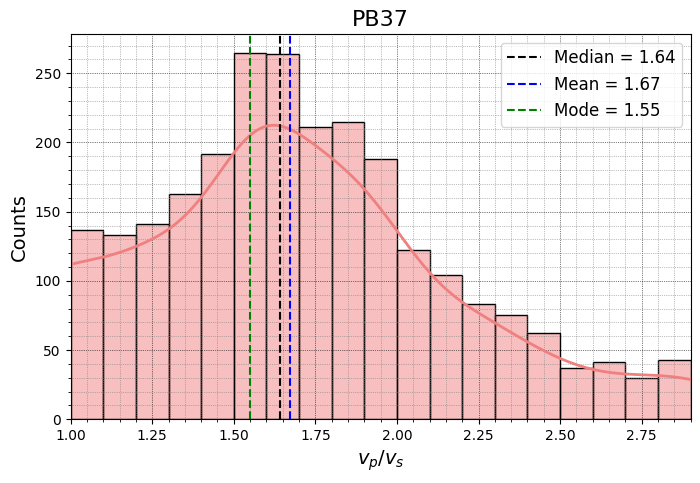

In [47]:
bins = np.arange(1, 3, 0.1)
plot_vij_histogram(iqr_results_df,station_name,bins=bins,output=output_fig)